# P1: kNN Source Separation

In [1]:
import librosa
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sig_trn, sr_trn = librosa.load('data/trs.wav',sr = None)

sig_trs, sr_trs = librosa.load('data/trn.wav',sr = None)

In [3]:
ipd.Audio(sig_trn,rate=sr_trn)

In [4]:
ipd.Audio(sig_trs,rate=sr_trs)

Applying STFT with 1024 point frames and 50% overlap and by using Han Window

In [5]:
S = librosa.stft(sig_trn, n_fft = 1024, hop_length= 1024//2, window='hann')
N = librosa.stft(sig_trs, n_fft = 1024, hop_length= 1024//2, window='hann')

In [6]:
G = S + N
print(G.shape)

(513, 989)


In [7]:
S_new_1 = np.absolute(S)
N_new_1 = np.absolute(N)
B = np.greater(S_new_1 , N_new_1).astype('int')

In [8]:
S_new = np.multiply(B , G)

In [9]:
S_recovered = librosa.istft(S_new,n_fft = 1024, hop_length= 1024//2, length = sig_trn.shape[0])

In [10]:
ipd.Audio(S_recovered,rate=sr_trn)

In [11]:
sig_nmf, sr_nmf = librosa.load('data/x_nmf.wav',sr = None)

In [12]:
ipd.Audio(sig_nmf,rate=sr_nmf)

In [13]:
X = librosa.stft(sig_nmf, n_fft = 1024, hop_length= 1024//2, window='hann')

In [14]:
Y = np.abs(X)
print(Y.shape)

(513, 131)


In [19]:
G = np.abs(S + N)

In [20]:
k = 15
output_list = []
D = np.zeros(np.shape(Y))

In [21]:
D = np.zeros(np.shape(Y))

In [22]:
shape_1 = np.shape(Y)[1]
shape_2 = np.shape(Y)[0]

for i in range(shape_1):
    
    new_B = np.zeros((shape_2,1))
    
    Y_split = Y[:,i].reshape(-1,1)
    
    dist = np.square(np.subtract(Y_split,G))
    
    dist_sum = np.sum(dist, axis =0)
    
    maximum_values = np.argsort(dist_sum)[:k]
    
    for each in maximum_values:
        
        con_value = np.reshape(B[:,each],(shape_2,1))
        
        new_B = np.concatenate((new_B, np.reshape(B[:,each],(shape_2,1))),axis = 1)
    
    splice_B = new_B[:,1:]
        
    D[:,i] = np.median(splice_B[:,1:],axis = 1)
    

In [23]:
D.shape

(513, 131)

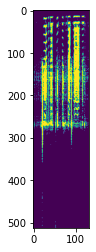

In [24]:
plt.imshow(D)

In [25]:
S_final = np.multiply(D,X)
rec = librosa.istft(S_final, hop_length = 512, length = sig_nmf.shape[0])

In [27]:
ipd.Audio(rec,rate = sr_nmf)

We can clearly see that the noise is suppressed in this case

# P2: Motor Imagery

In [43]:
import scipy.io
import scipy.linalg as la
from scipy.spatial.distance import hamming
import statistics as stat
import pandas as pd

In [44]:
eeg_data = scipy.io.loadmat('data/eeg.mat')

x_train = eeg_data['x_train']
x_test = eeg_data['x_te']
y_train = eeg_data['y_train']
y_test = eeg_data['y_te']

In [45]:
def stft_func(sig, N, hop, win):
    output = librosa.stft(sig, n_fft = N, hop_length = hop , window = win)
    return output

In [46]:
x_train[:,:,0].shape

(768, 3)

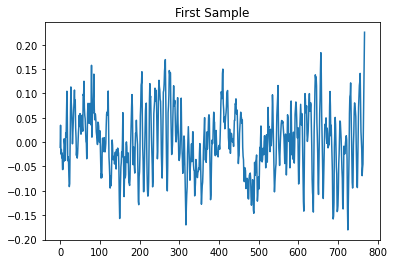

In [47]:
plt.title("First Sample")
sample = x_train[:,0,0]
plt.plot(sample)
plt.show()

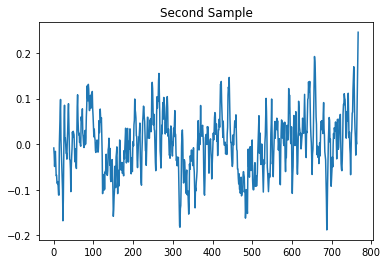

In [48]:
plt.title("Second Sample")
sample = x_train[:,1,0]
plt.plot(sample)
plt.show()

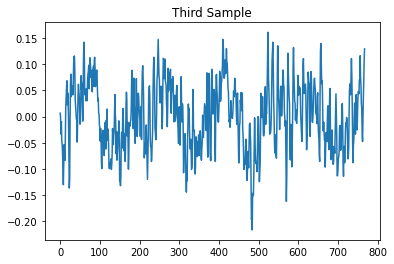

In [49]:
plt.title("Third Sample")
sample = x_train[:,2,0]
plt.plot(sample)
plt.show()

In [50]:
def get_x_func(x):
    
    data_list = []
    
    N = 64
    hop = 48
    window = 'blackman'

    for i in range(x.shape[2]):
        
        time_channel_3 = x[:, 0, i]
        time_channel_z = x[:, 1, i]
        time_channel_4 = x[:, 2, i]

        freq_channel_3 = stft_func(time_channel_3, N, hop, window)
        freq_channel_z = stft_func(time_channel_z, N, hop, window)
        freq_channel_4 = stft_func(time_channel_4, N, hop, window)

        mu_channel_3 = freq_channel_3[3:8]
        mu_channel_z = freq_channel_z[3:8]
        mu_channel_4 = freq_channel_4[3:8]

        mu_channel_3 = np.reshape(mu_channel_3, (-1, 1))
        mu_channel_z = np.reshape(mu_channel_z, (-1, 1))
        mu_channel_4 = np.reshape(mu_channel_4, (-1, 1))

        all_sample_data = np.vstack((mu_channel_3, mu_channel_z, mu_channel_4))

        data_list.append(all_sample_data)

    output = np.hstack((data_list))
    
    return output

In [51]:
def A_func(L,M):
    
    A_con = np.random.uniform(-1,1,L)

    A = np.random.uniform(-1,1,L)
    
    for i in range(len(M) - 1):
        A = np.vstack((A,A_con))
    
    A_list = []
    for j in range(len(train_data)):
        
        A_list.append(sum(A[j]))
        
    A_list = np.array(A_list)
    A_inv = 1/A_list
    
    B = A * A_inv[:, np.newaxis]   

    return B.T

In [52]:
def distance_func(Y,Y_test):
    
    init_val = np.zeros((28,112))
    
    r = init_val.shape[0]
    c = init_val.shape[1]
    
    y_t = Y_test.shape[1]
    y = Y.shape[1]
    
    for i in range(r):
        
        for j in range(c):
            
            init_val[i][j] = np.count_nonzero(Y_test[:,i] != Y[:,j])
    
    dist_index = init_val.argsort()
    
    output = np.zeros((y_t,y))
    
    for i in range(y_t):
        
        for j in range(y):
            
            val = dist_index[i][j]
            
            output[i][j] = y_train[val,0]
            
    return output

In [73]:
N = 64

skip_1 = 5
skip_2 = 2

train_data = get_x_func(x_train)
test_data = get_x_func(x_test)

y_shape = y_test.shape[0]

val_arr_1 = []
val_arr_2 = []
fin_arr = []

for each_1 in range(10,100,skip_1): 
    
    for each_2 in range(3,27,skip_2): 
        
        temp_count = 0 
        
        temp_1 = each_1
        
        temp_2 = each_2
        
        A = A_func(temp_1,train_data)

        Y = np.dot(A,train_data)
        
        Y_sign = np.sign(Y)
        
        Y_test = np.dot(A,test_data)
                
        Y_test_sign = np.sign(Y_test)
        
        dist_val = distance_func(Y_sign,Y_test_sign)
        
        k_dist_val = dist_val[:,0:temp_2]        
        
        test_val = np.zeros((y_shape,1))
        
        for each_3 in range(0,(y_shape)):
            
            splice_dist = k_dist_val[each_3,:]
            
            test_val[each_3] = stat.mode(splice_dist)

        
        for each_4 in range(0,(y_shape)):
            
            if test_val[each_4] == y_test[each_4]:
                
                temp_count+=1

        ratio_val = temp_count/(y_test.shape[0])
        

        val_arr_1.append(each_1)
        val_arr_2.append(each_2)
        fin_arr.append(ratio_val)
        
        
        

val_arr_1 = np.array(val_arr_1).reshape((-1,1))

val_arr_2 = np.array(val_arr_2).reshape((-1,1))

fin_arr = np.array(fin_arr).reshape((-1,1))



stack_val = np.hstack((val_arr_1,val_arr_2))
output_val = np.hstack((stack_val,fin_arr))

index_sort = output_val[:,2].argsort()

output_val_sort = output_val[index_sort]

k_nearest_val = output_val_sort[::-1][0:18]

output = pd.DataFrame(k_nearest_val, columns=['L', 'K', 'Accuracy'])

print(output)

       L     K  Accuracy
0   55.0  13.0  0.785714
1   45.0   3.0  0.750000
2   45.0  21.0  0.714286
3   35.0  23.0  0.642857
4   45.0  15.0  0.642857
5   95.0   7.0  0.642857
6   25.0   5.0  0.642857
7   20.0  19.0  0.607143
8   20.0  17.0  0.607143
9   80.0  21.0  0.607143
10  35.0   7.0  0.607143
11  45.0  23.0  0.607143
12  85.0  23.0  0.607143
13  60.0   3.0  0.607143
14  10.0  19.0  0.607143
15  25.0  17.0  0.607143
16  10.0  25.0  0.607143
17  90.0   5.0  0.607143


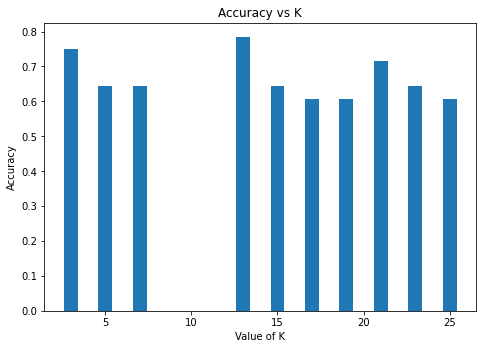

In [98]:
plot = plt.figure()
axes = plot.add_axes([0,0,1,1])

acc = k_nearest_val[:,2]
val = k_nearest_val[:,1]

axes.bar(val,acc)
axes.set_ylabel('Accuracy')
axes.set_xlabel('Value of K')
axes.set_title('Accuracy vs K')
plt.show()

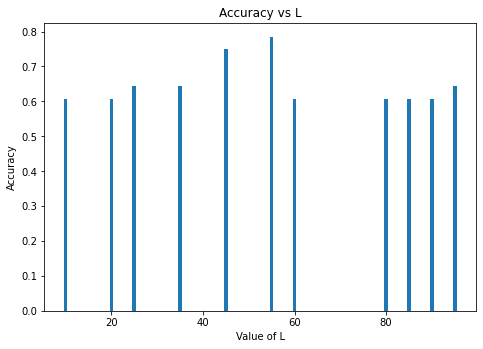

In [99]:
plot = plt.figure()
axes = plot.add_axes([0,0,1,1])

acc = k_nearest_val[:,2]
val = k_nearest_val[:,0]

axes.bar(val,acc)
axes.set_ylabel('Accuracy')
axes.set_xlabel('Value of L')
axes.set_title('Accuracy vs L')
plt.show()

When we compare this graph with the M5 S37 Naive Bayes result then we can conclude that it is almost similar. 

The performance by the binary variables classifier is good as there are no big performance drop and we got an accuracy value of 0.78 for K=13.0 and 0.75 for K=3.0.

# P3: Multidimensional Scaling

In [74]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import math
import scipy.linalg as la

In [75]:
mat = scipy.io.loadmat('data/MDS_pdist.mat')

In [76]:
M = np.array(mat['L'])

In [77]:
M.shape

(996, 996)

In [78]:
row_avg = np.mean(M, axis=1)

In [79]:
M_bar = (M.transpose() - row_avg).transpose()

In [80]:
M_bar.shape

(996, 996)

In [81]:
col_avg = np.mean(np.array(M_bar), axis=0)

In [82]:
W = M_bar - col_avg

In [83]:
W.shape

(996, 996)

In [84]:
w, v = la.eig(W)

In [85]:
w_sorted = np.sort(w)[::-1]

In [86]:
eig_order = []
for i in w_sorted:
    eig_order.append((np.where(w == i)[0][0]))

In [87]:
v_sorted = np.zeros((1, 996), dtype = int)
for i,value in enumerate(eig_order):
    v_sorted = np.concatenate((v_sorted, v.T[value].reshape(1,996)), axis=0)

In [88]:
v_sorted = v_sorted[1:,:][:,:2]

In [89]:
v_sorted.shape

(996, 2)

In [90]:
x = v_sorted[:1,:]

In [91]:
y = v_sorted[1:2,:]

In [92]:
x.shape

(1, 2)

In [93]:
y.shape

(1, 2)

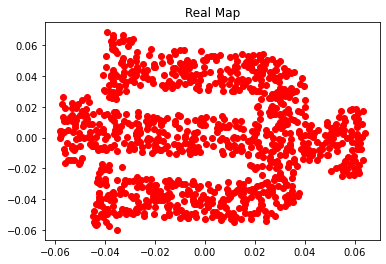

In [96]:
plt.scatter(v[:,0],v[:,1], c = 'red')
plt.title('Real Map')
plt.show()

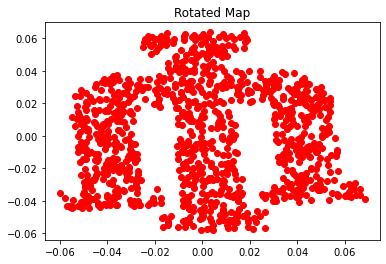

In [97]:
plt.scatter(v[:,1],v[:,0], c = "red")
plt.title('Rotated Map')
plt.show()